# Import bibliotek i tworzenie obiektów

In [1]:
%%capture
pip install h2o_pysparkling_3.2

In [2]:
%%capture
pip install synapse

In [3]:
%%capture
pip install synapseml

In [4]:
import os
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import IntegerType, DoubleType
import pyspark.sql.functions as F

In [5]:
from sklearn.linear_model import LogisticRegression as LogisticRegression_scikit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [6]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
N_CORES = 12

In [8]:
CREATE_TIME_DATA = False  # Sterowanie tworzeniem plików z czasem wykonania modelu
USE_SCIKIT_MODEL = True  # Sterowanie użyciem modelu Logistic Regression z sci-kit (bardzo wolny)

In [9]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("tbd") \
.master(f"local[{N_CORES}]") \
.config("spark.jars.packages", "com.microsoft.azure:synapseml_2.12:0.10.2") \
.config("spark.jars.repositories", "https://mmlspark.azureedge.net/maven") \
.config("spark.executor.instances", "2") \
.config('spark.driver.memory','4g') \
.config('spark.executor.memory', '2g') \
.config("spark.executor.cores", N_CORES) \
.getOrCreate()
from pysparkling import *
from pysparkling.ml import H2OGLM
from pysparkling.ml import H2OXGBoostClassifier
import h2o
hc = H2OContext.getOrCreate()

Connecting to H2O server at http://3ce230c0184c:54323 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,4 days
H2O_cluster_name:,sparkling-water-jovyan_local-1673289602780
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"



Sparkling Water Context:
 * Sparkling Water Version: 3.38.0.4-1-3.2
 * H2O name: sparkling-water-jovyan_local-1673289602780
 * cluster size: 1
 * list of used nodes:
  (executorId, host, port)
  ------------------------
  (0,172.17.0.2,54321)
  ------------------------

  Open H2O Flow in browser: http://3ce230c0184c:54323 (CMD + click in Mac OSX)

    


In [10]:
from synapse.ml.lightgbm import LightGBMClassifier

# Wczytywanie danych i preprocessing

### Selekcja cech

In [11]:
# Mały zbiór danych tylko do selekcji cech
csv_path = 'ds1_1e4.csv'

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [13]:
spark_df = spark.read.options(header='True', inferSchema='True', delimiter=',').csv(f"{csv_path}")

In [14]:
all_features = ['V1', 'Accident_Index', 'Location_Easting_OSGR',
       'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force','Number_of_Vehicles', 'Number_of_Casualties',
       'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)',
       'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number',
       'Road_Type', 'Speed_limit', 'Junction_Control', '2nd_Road_Class',
       '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control',
       'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions',
       'Weather_Conditions', 'Road_Surface_Conditions',
       'Special_Conditions_at_Site', 'Carriageway_Hazards',
       'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident',
       'LSOA_of_Accident_Location', 'Year']
indexed_columns = ['si_' + c for c in all_features]
stringindexer_stages_fs = [StringIndexer(inputCol=c, outputCol='si_' + c).setHandleInvalid("keep") for c in all_features]

In [15]:
indexed_df = Pipeline(stages=stringindexer_stages_fs).fit(spark_df).transform(spark_df)

In [16]:
indexed_df = indexed_df.select(indexed_columns + ['label']).toPandas()

In [17]:
data = pd.read_csv(csv_path)

X = indexed_df[indexed_columns]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [18]:
sorted_idx = rf.feature_importances_.argsort().astype(int)

In [19]:
final_features = []
for i in sorted_idx:
    final_features.append(indexed_columns[i])

In [20]:
new_rf = rf.feature_importances_[sorted_idx]

<BarContainer object of 32 artists>

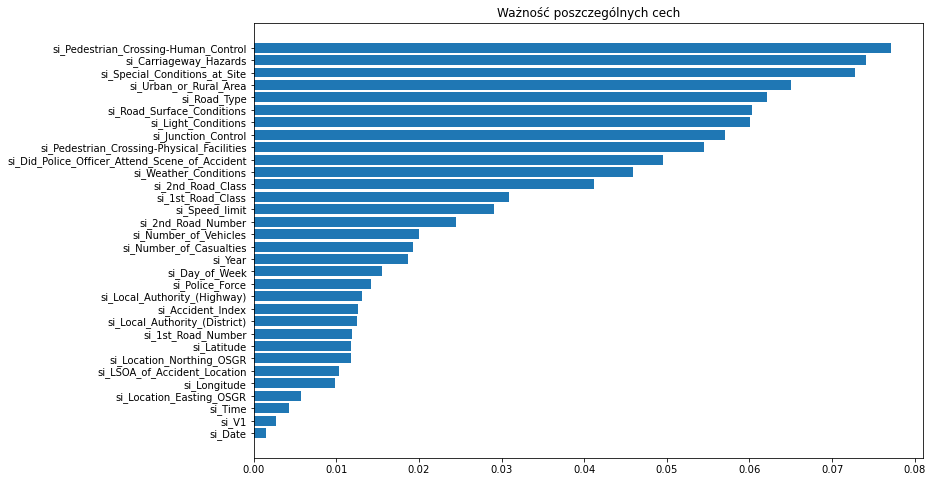

In [21]:
plt.figure(figsize=(12,8))
plt.title('Ważność poszczególnych cech')
plt.barh(np.flip(np.array(indexed_columns)[sorted_idx]), new_rf)

Powyżej znajduję się wykres na którym widać, które cechy są najmniej i najbardziej istotne dla modelu. Widać, że największy wpływ na uczenie mają wpływ takie zmienne jak Pedestrian_Crossing-Human Control, Carriageaway_Hazards, Specal_Conditions_at_Site, Urban_or_ Rural Area.

### Wczytywanie danych i preprocessing

In [22]:
csv_path = 'ds1_1e5.csv'
if USE_SCIKIT_MODEL:
    csv_path = 'ds1_1e5.csv'

In [23]:
spark_df = spark.read.options(header='True', inferSchema='True', delimiter=',').csv(f"{csv_path}")

In [24]:
from pyspark.sql.functions import udf

def ignore_colon(x):
    if x:
        return x.replace(':','')
    else:
        return None

colon_udf = udf(ignore_colon)

spark_df = spark_df.withColumn('Light_Conditions', colon_udf('Light_Conditions'))

In [25]:
# rzutowanie 'label' (boolean) na Integer
spark_df = spark_df.withColumn('label', F.when(spark_df.label == 'false', 0).otherwise(1))

Poniższe feature_columns zostało wybrane na podstawie wcześniejszej selekcji cech.

In [26]:
y = 'label'
#Wybór kolumn używanych w modelu
feature_columns = ['Pedestrian_Crossing-Human_Control','Carriageway_Hazards','Special_Conditions_at_Site','Urban_or_Rural_Area','Road_Surface_Conditions',
                   'Road_Type','Junction_Control','Pedestrian_Crossing-Physical_Facilities','Light_Conditions', 'Weather_Conditions',
                   'Did_Police_Officer_Attend_Scene_of_Accident','2nd_Road_Class', '1st_Road_Class','Speed_limit', '2nd_Road_Number',
                   'Number_of_Vehicles','Number_of_Casualties']

In [27]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in feature_columns]
onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehot_' + c) for c in feature_columns]

In [28]:
extracted_columns = ['onehot_' + c for c in feature_columns]
vectorassembler_stage = VectorAssembler(inputCols=extracted_columns, outputCol='features')

In [29]:
final_columns = [y] + feature_columns + extracted_columns + ['features']

In [30]:
transformed_df = Pipeline(stages=stringindexer_stages + \
                          onehotencoder_stages + \
                          [vectorassembler_stage] \
                         ).fit(spark_df).transform(spark_df).select(final_columns)

In [31]:
training, test = transformed_df.randomSplit([0.8, 0.2], seed=1234)

### Transformacja danych dla modelu scikit-learn

In [32]:
if USE_SCIKIT_MODEL:
    training_sklr = training.toPandas()
    test_sklr = test.toPandas()

    X_train = training_sklr['features'].tolist()
    Y_train = training_sklr['label'].tolist()

    X_test = test_sklr['features'].tolist()
    Y_test = test_sklr['label'].tolist()

# Tworzenie modeli - Logistic Regression

#### Tworzenie metryk

In [33]:
evaluator_ACC = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                        metricName="precisionByLabel", metricLabel=1.)
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                        metricName="recallByLabel", metricLabel=1.)
evaluator_precision_other = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                        metricName="precisionByLabel", metricLabel=0.)
evaluator_recall_other = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction",
                                                        metricName="recallByLabel", metricLabel=0.)

#### Pomiar czasu

Dane nt. czasu trenowania modeli dla uruchomienia z pewną ilością rdzeni przechowywane będą w tworzonych plikach .csv. Podyktowane jest to koniecznością resetowania kernela przy zmianie ilości rdzeni.

In [34]:
time_df = pd.DataFrame(columns = ['n_cores', 'implementation','time'])

### sparkML Logistic Regression

In [35]:
start = time.time()

lr = LogisticRegression(featuresCol='features', labelCol='label')
simple_model = Pipeline(stages=[lr]).fit(training)

end = time.time()

t = end - start
imp_time = {'n_cores':N_CORES, 'implementation':'sparkML_LR', 'time': t}
time_df = time_df.append(imp_time, ignore_index = True)
print(t)

10.877148151397705


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [36]:
pred_simple = simple_model.transform(test)
pred_simple = pred_simple.withColumn('prediction', pred_simple['prediction'].cast(DoubleType()))

accuracy1 = evaluator_ACC.evaluate(pred_simple)
precision1 = evaluator_precision.evaluate(pred_simple)
recall1 = evaluator_recall.evaluate(pred_simple)
precision1_other = evaluator_precision_other.evaluate(pred_simple)
recall1_other = evaluator_recall_other.evaluate(pred_simple)
f1_1 = 2*(precision1*recall1)/(precision1+recall1)

### H2O Sparkling Water Logistic Regression

In [37]:
start = time.time()

lr_h2o = H2OGLM(family='binomial', featuresCols=['features'], labelCol='label', detailedPredictionCol='rawPrediction_u', seed=2137)
simple_model_h2o = Pipeline(stages=[lr_h2o]).fit(training)

end = time.time()

t = end - start
imp_time = {'n_cores':N_CORES, 'implementation':'H2O_Sparkling_Water_LR', 'time': t}
time_df = time_df.append(imp_time, ignore_index = True)
print(t)

21.387706518173218


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [38]:
pred_simple_h2o = simple_model_h2o.transform(test)
pred_simple_h2o = pred_simple_h2o.withColumn('prediction', pred_simple_h2o['prediction'].cast(DoubleType()))

accuracy2 = evaluator_ACC.evaluate(pred_simple_h2o)
precision2 = evaluator_precision.evaluate(pred_simple_h2o)
recall2 = evaluator_recall.evaluate(pred_simple_h2o)
precision2_other = evaluator_precision_other.evaluate(pred_simple_h2o)
recall2_other = evaluator_recall_other.evaluate(pred_simple_h2o)
f1_2 = 2*(precision2*recall2)/(precision2+recall2)

### scikit-learn Logistic Regression

In [39]:
if USE_SCIKIT_MODEL:
    start = time.time()

    lr_sklr = LogisticRegression_scikit(random_state=2137, solver='lbfgs', max_iter=1000).fit(X_train, Y_train)

    end = time.time()

    t = end - start
    imp_time = {'n_cores':N_CORES, 'implementation':'scikit-learn_LR', 'time': t}
    time_df = time_df.append(imp_time, ignore_index = True)
    print(t)

1335.520060300827


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [40]:
if USE_SCIKIT_MODEL:
    Y_pred = lr_sklr.predict(X_test)

    accuracy3 = accuracy_score(Y_test, Y_pred)
    f1_3 = f1_score(Y_test, Y_pred, pos_label=1)
    precision3 = precision_score(Y_test, Y_pred, pos_label=1)
    recall3 = recall_score(Y_test, Y_pred, pos_label=1)
    precision3_other = precision_score(Y_test, Y_pred, pos_label=0)
    recall3_other = recall_score(Y_test, Y_pred, pos_label=0)

#### Pomiar czasu

In [41]:
result_path = f"time_res_ncores_{N_CORES}"
if CREATE_TIME_DATA:
    time_df.to_csv(result_path)

# Wyniki - Logistic Regression

In [42]:
results_df_lr = pd.DataFrame(columns = ['model','ACC','F1','Precision','Recall','Precision_zeros','Recall_zeros'])

resoults1 = {'model': 'sparkML Logistic Regression', 'ACC': accuracy1, 'F1': f1_1, 'Precision': precision1, 'Recall': recall1, 'Precision_zeros': precision1_other,'Recall_zeros': recall1_other}
resoults2 = {'model': 'H2O Sparkling Water Logistic Regression', 'ACC': accuracy2, 'F1': f1_2, 'Precision': precision2, 'Recall': recall2, 'Precision_zeros': precision2_other,'Recall_zeros': recall2_other}
if USE_SCIKIT_MODEL:
    resoults3 = {'model': 'scikit-learn Logistic Regression', 'ACC': accuracy3, 'F1': f1_3, 'Precision': precision3, 'Recall': recall3, 'Precision_zeros': precision3_other,'Recall_zeros': recall3_other}

results_df_lr = results_df_lr.append(resoults1, ignore_index = True)
results_df_lr = results_df_lr.append(resoults2, ignore_index = True)
if USE_SCIKIT_MODEL:
    results_df_lr = results_df_lr.append(resoults3, ignore_index = True)

results_df_lr

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,model,ACC,F1,Precision,Recall,Precision_zeros,Recall_zeros
0,sparkML Logistic Regression,0.846898,0.916944,0.850336,0.994873,0.289256,0.011777
1,H2O Sparkling Water Logistic Regression,0.846797,0.916866,0.850464,0.994515,0.297710,0.013122
2,scikit-learn Logistic Regression,0.849633,0.918664,0.849823,0.999642,0.600000,0.003028


# Tworzenie modeli - GBT, XGBoost, Light-GBM

### sparkML GBT

In [43]:
start = time.time()

gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
simple_model_gbt = Pipeline(stages=[gbt]).fit(training)

end = time.time()

t = end - start
imp_time = {'n_cores':N_CORES, 'implementation':'sparkML_GBT', 'time': t}
time_df = time_df.append(imp_time, ignore_index = True)
print(t)

32.2990460395813


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [44]:
pred_simple_gbt = simple_model_gbt.transform(test)
pred_simple_gbt = pred_simple_gbt.withColumn('prediction', pred_simple_gbt['prediction'].cast(DoubleType()))

accuracy1 = evaluator_ACC.evaluate(pred_simple_gbt)
precision1 = evaluator_precision.evaluate(pred_simple_gbt)
recall1 = evaluator_recall.evaluate(pred_simple_gbt)
precision1_other = evaluator_precision_other.evaluate(pred_simple_gbt)
recall1_other = evaluator_recall_other.evaluate(pred_simple_gbt)
f1_1 = 2*(precision1*recall1)/(precision1+recall1)

### H2O Sparkling Water XGBoost

In [45]:
start = time.time()

xgboost = H2OXGBoostClassifier(labelCol = "label", featuresCols=['features'])
simple_model_xgb = Pipeline(stages=[xgboost]).fit(training)

end = time.time()

t = end - start
imp_time = {'n_cores':N_CORES, 'implementation':'H2O_Sparkling_Water_XGBoost', 'time': t}
time_df = time_df.append(imp_time, ignore_index = True)
print(t)

13.021783351898193


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [46]:
pred_simple_xgb = simple_model_xgb.transform(test)
pred_simple_xgb = pred_simple_xgb.withColumn('prediction', pred_simple_xgb['prediction'].cast(DoubleType()))

accuracy2 = evaluator_ACC.evaluate(pred_simple_xgb)
precision2 = evaluator_precision.evaluate(pred_simple_xgb)
recall2 = evaluator_recall.evaluate(pred_simple_xgb)
precision2_other = evaluator_precision_other.evaluate(pred_simple_xgb)
recall2_other = evaluator_recall_other.evaluate(pred_simple_xgb)
f1_2 = 2*(precision2*recall2)/(precision2+recall2)

### SynapseML Light-GBM

In [47]:
start = time.time()

gbm = LightGBMClassifier(objective="binary", featuresCol="features", labelCol="label", isUnbalance=True)
simple_model_gbm = Pipeline(stages=[gbm]).fit(training)

end = time.time()

t = end - start
imp_time = {'n_cores':N_CORES, 'implementation':'synapseML_light-GBM', 'time': t}
time_df = time_df.append(imp_time, ignore_index = True)
print(t)

3.095107078552246


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


In [48]:
pred_simple_gbm = simple_model_gbm.transform(test)
pred_simple_gbm = pred_simple_gbm.withColumn('prediction', pred_simple_gbm['prediction'].cast(DoubleType()))

accuracy3 = evaluator_ACC.evaluate(pred_simple_gbm)
precision3 = evaluator_precision.evaluate(pred_simple_gbm)
recall3 = evaluator_recall.evaluate(pred_simple_gbm)
precision3_other = evaluator_precision_other.evaluate(pred_simple_gbm)
recall3_other = evaluator_recall_other.evaluate(pred_simple_gbm)
f1_3 = 2*(precision3*recall3)/(precision3+recall3)

#### Pomiar czasu

In [49]:
result_path = f"time_res_both_ncores_{N_CORES}"
if CREATE_TIME_DATA:
    time_df.to_csv(result_path)

# Wyniki - GBT, XGBoost, Light-GBM

In [50]:
results_df_rest = pd.DataFrame(columns = ['model','ACC','F1','Precision','Recall','Precision_zeros','Recall_zeros'])

resoults1 = {'model': 'sparkML GBT', 'ACC': accuracy1, 'F1': f1_1, 'Precision': precision1, 'Recall': recall1, 'Precision_zeros': precision1_other,'Recall_zeros': recall1_other}
resoults2 = {'model': 'H2O Sparkling Water XGBoost', 'ACC': accuracy2, 'F1': f1_2, 'Precision': precision2, 'Recall': recall2, 'Precision_zeros': precision2_other,'Recall_zeros': recall2_other}
resoults3 = {'model': 'SynapseML Light-GBM', 'ACC': accuracy3, 'F1': f1_3, 'Precision': precision3, 'Recall': recall3, 'Precision_zeros': precision3_other,'Recall_zeros': recall3_other}

results_df_rest = results_df_rest.append(resoults1, ignore_index = True)
results_df_rest = results_df_rest.append(resoults2, ignore_index = True)
results_df_rest = results_df_rest.append(resoults3, ignore_index = True)

results_df_rest

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,model,ACC,F1,Precision,Recall,Precision_zeros,Recall_zeros
0,sparkML GBT,0.849481,0.918575,0.849800,0.999463,0.500000,0.003028
1,H2O Sparkling Water XGBoost,0.849126,0.918265,0.850564,0.997675,0.450704,0.010767
2,SynapseML Light-GBM,0.657230,0.769089,0.899019,0.671973,0.236681,0.574024


# Wyniki - Skalowalność względem ilości rdzeni

In [51]:
list_n_cores = [1,2,3,4,5,6,8,12]

time_df_plot = None
for n_core in list_n_cores:
    if time_df is not None:
        temp_df = pd.read_csv(f"time_res_both_ncores_{n_core}")
        time_df_plot = pd.concat([time_df_plot, temp_df], axis=0)
    else:
        time_df_plot = pd.read_csv(f"time_res_both_ncores_{n_core}")

In [52]:
time_df_plot['relative_perf'] = time_df_plot.apply(lambda row: (1/row.time) * (1/row.n_cores), axis=1)

<AxesSubplot:title={'center':'Czas trenowania modelu w zależności od liczby rdzeni'}, xlabel='liczba rdzeni', ylabel='czas [s]'>

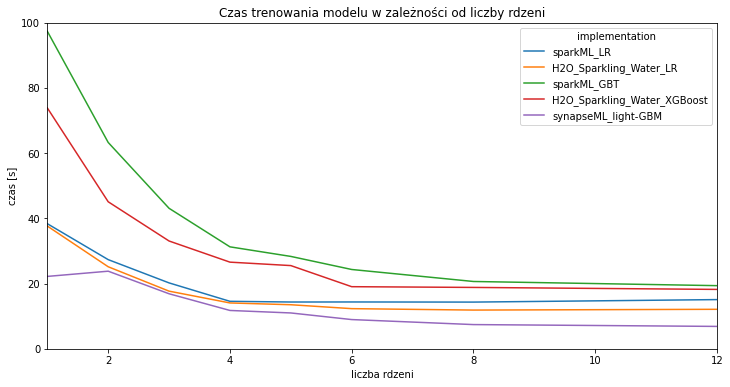

In [53]:
df_plot = time_df_plot.pivot(index='n_cores', columns='implementation', values='time')
df_plot = df_plot[['sparkML_LR', 'H2O_Sparkling_Water_LR', 'sparkML_GBT', 'H2O_Sparkling_Water_XGBoost', 'synapseML_light-GBM']]
df_plot.plot(figsize=(12,6), ylabel='czas [s]', xlabel='liczba rdzeni',
             title='Czas trenowania modelu w zależności od liczby rdzeni', xlim=[1,12], ylim=[0,100])

<AxesSubplot:title={'center':'Wydajność pojedynczego rdzenia'}, xlabel='liczba rdzeni', ylabel='1/(czas * liczba rdzeni)'>

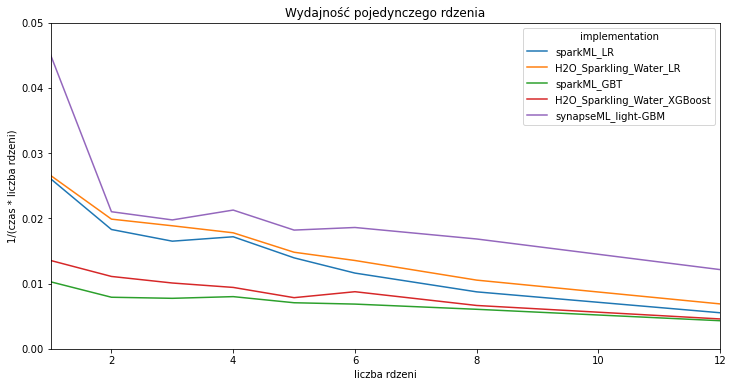

In [54]:
df_plot = time_df_plot.pivot(index='n_cores', columns='implementation', values='relative_perf')
df_plot = df_plot[['sparkML_LR', 'H2O_Sparkling_Water_LR', 'sparkML_GBT', 'H2O_Sparkling_Water_XGBoost', 'synapseML_light-GBM']]
df_plot.plot(figsize=(12,6), ylabel='1/(czas * liczba rdzeni)', xlabel='liczba rdzeni',
             title='Wydajność pojedynczego rdzenia', xlim=[1,12], ylim=[0,0.05])

## 5a. które modele się lepiej skalują ##

Najlepiej skalują się algorytmy i H2O_Sparkling_Water_XGBoost - dla nich wyliczona wydajność pojedynczego rdzenia spada najwolniej wraz z ilością rdzeni. Z drugiej strony algorytm synapseML_light-GBM skaluje się bardzo źle.

# Optymalizacja hiperparametrów + Cross Validation

## Ponowne wczytanie i przetworzenie zbioru danych (mniejszego) w celu dokonania optymalizacji i CV

In [55]:
csv_path = 'ds1_1e4.csv'

In [56]:
spark_df = spark.read.options(header='True', inferSchema='True', delimiter=',').csv(f"{csv_path}")

In [57]:
from pyspark.sql.functions import udf

def ignore_colon(x):
    if x:
        return x.replace(':','')
    else:
        return None

colon_udf = udf(ignore_colon)

spark_df = spark_df.withColumn('Light_Conditions', colon_udf('Light_Conditions'))

In [58]:
# rzutowanie 'label' (boolean) na Integer
spark_df = spark_df.withColumn('label', F.when(spark_df.label == 'false', 0).otherwise(1))

In [59]:
y = 'label'
#Wybór kolumn używanych w modelu
feature_columns = ['Pedestrian_Crossing-Human_Control','Carriageway_Hazards','Special_Conditions_at_Site','Urban_or_Rural_Area','Road_Surface_Conditions',
                   'Road_Type','Junction_Control','Pedestrian_Crossing-Physical_Facilities','Light_Conditions', 'Weather_Conditions',
                   'Did_Police_Officer_Attend_Scene_of_Accident','2nd_Road_Class', '1st_Road_Class','Speed_limit', '2nd_Road_Number',
                   'Number_of_Vehicles','Number_of_Casualties']

In [60]:
stringindexer_stages = [StringIndexer(inputCol=c, outputCol='stringindexed_' + c).setHandleInvalid("keep") for c in feature_columns]
onehotencoder_stages = [OneHotEncoder(inputCol='stringindexed_' + c, outputCol='onehot_' + c) for c in feature_columns]

In [61]:
extracted_columns = ['onehot_' + c for c in feature_columns]
vectorassembler_stage = VectorAssembler(inputCols=extracted_columns, outputCol='features')

In [62]:
final_columns = [y] + feature_columns + extracted_columns + ['features']

In [63]:
transformed_df = Pipeline(stages=stringindexer_stages + \
                          onehotencoder_stages + \
                          [vectorassembler_stage] \
                         ).fit(spark_df).transform(spark_df).select(final_columns)

In [64]:
training, test = transformed_df.randomSplit([0.8, 0.2], seed=1234)

## Optymalizacja hiperparametrów + Cross Validation

In [65]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.tuning import CrossValidator

In [66]:
##GBT
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
param_grid = ParamGridBuilder().\
    addGrid(gbt.maxDepth, [2,3,4,5,6]).\
    build()

cv = CrossValidator(estimator = gbt, estimatorParamMaps=param_grid, evaluator=evaluator_ACC, numFolds=4)
cv_model = cv.fit(training)
pred_simple_gbt = cv_model.transform(test)

In [67]:
pred_simple_gbt = pred_simple_gbt.withColumn('prediction', pred_simple_gbt['prediction'].cast(DoubleType()))

accuracy1 = evaluator_ACC.evaluate(pred_simple_gbt)
precision1 = evaluator_precision.evaluate(pred_simple_gbt)
recall1 = evaluator_recall.evaluate(pred_simple_gbt)
precision1_other = evaluator_precision_other.evaluate(pred_simple_gbt)
recall1_other = evaluator_recall_other.evaluate(pred_simple_gbt)
f1_1 = 2*(precision1*recall1)/(precision1+recall1)

In [68]:
results_df_lr_opt = pd.DataFrame(columns = ['model','ACC','F1','Precision','Recall','Precision_zeros','Recall_zeros'])

resoults2 = {'model': 'sparkML GBT OPTIMIZED', 'ACC': accuracy1, 'F1': f1_1, 'Precision': precision1, 'Recall': recall1, 'Precision_zeros': precision1_other,'Recall_zeros': recall1_other}

results_df_lr_opt = results_df_lr_opt.append(resoults2, ignore_index = True)

results_df_lr_opt

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,model,ACC,F1,Precision,Recall,Precision_zeros,Recall_zeros
0,sparkML GBT OPTIMIZED,0.844793,0.915867,0.844793,1.0,0.0,0.0


## 5b. które implementacje są bardziej wydajne ##
W poniższej tabeli widać, że pomiędzy  sparkML GBT, a H2O Sparkling Water XGBoost nie ma dużej różnicy w wynikach. Można wysunąć wniosek, że wydajnościowo są one na podobnym poziomie.
Problem pojawia się przy SynapseML Light-GBM, który jest dużo mniej wydajny (ACC mniejsze aż o 0.2)

In [69]:
results_df_rest

,model,ACC,F1,Precision,Recall,Precision_zeros,Recall_zeros
0,sparkML GBT,0.849481,0.918575,0.849800,0.999463,0.500000,0.003028
1,H2O Sparkling Water XGBoost,0.849126,0.918265,0.850564,0.997675,0.450704,0.010767
2,SynapseML Light-GBM,0.657230,0.769089,0.899019,0.671973,0.236681,0.574024


In [70]:
lr = LogisticRegression(featuresCol='features', labelCol='label')
param_grid = ParamGridBuilder().\
    addGrid(lr.regParam, [0, 0.3, 0.6, 0.8]).\
    build()

cv = CrossValidator(estimator = lr, estimatorParamMaps=param_grid, evaluator=evaluator_ACC, numFolds=4)
cv_model = cv.fit(training)
pred_lr = cv_model.transform(test)

In [71]:
pred_lr = pred_lr.withColumn('prediction', pred_lr['prediction'].cast(DoubleType()))

accuracy2 = evaluator_ACC.evaluate(pred_lr)
precision2 = evaluator_precision.evaluate(pred_lr)
recall2 = evaluator_recall.evaluate(pred_lr)
precision2_other = evaluator_precision_other.evaluate(pred_lr)
recall2_other = evaluator_recall_other.evaluate(pred_lr)
f1_2 = 2*(precision2*recall2)/(precision2+recall2)

In [72]:
results_df_rest_opt = pd.DataFrame(columns = ['model','ACC','F1','Precision','Recall','Precision_zeros','Recall_zeros'])

resoults2 = {'model': 'H2O Sparkling Water Logistic Regression OPTIMIZED', 'ACC': accuracy2, 'F1': f1_2, 'Precision': precision2, 'Recall': recall2, 'Precision_zeros': precision2_other,'Recall_zeros': recall2_other}

results_df_rest_opt = results_df_rest_opt.append(resoults2, ignore_index = True)

results_df_rest_opt

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,model,ACC,F1,Precision,Recall,Precision_zeros,Recall_zeros
0,H2O Sparkling Water Logistic Regression OPTIMIZED,0.844793,0.915867,0.844793,1.0,0.0,0.0



W poniższej tabeli znajduję się porównanie wydajności regresji logistycznej dla 3 bibliotek. Analizując wyniki można wysunąć wniosek, że wydajnościowo wszystko użyte implementację są na podobnym poziomie.

In [73]:
results_df_lr

,model,ACC,F1,Precision,Recall,Precision_zeros,Recall_zeros
0,sparkML Logistic Regression,0.846898,0.916944,0.850336,0.994873,0.289256,0.011777
1,H2O Sparkling Water Logistic Regression,0.846797,0.916866,0.850464,0.994515,0.297710,0.013122
2,scikit-learn Logistic Regression,0.849633,0.918664,0.849823,0.999642,0.600000,0.003028


## 5c czy dla wszystkich modeli wystarczył ten sam pre-processing? ##
Nie, dla przykładu model GBM nie mógł wczytać niektórych znaków specjalnych (,:{}). Scikit learn za to  potrzebował oddzielnej preparacji danych.
Różne modele z różnych bibliotek mogą wymagać innego preproccesingu. 
